In [38]:
import os
import keyring

from typing import Annotated, Literal, List, Optional, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent

from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

# Setup for tools
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

In [39]:
# tavily search tool
tavily_tool = TavilySearchResults(max_results=5)

# Set web search and scraping tools
@tool
def scrape_webpages(urls: List[str]) -> str:
    """ Use requests and bs4 ro scrape the provideed web pages for detailed information. """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )
    
# Define the tools
tools = [
    tavily_tool,
    scrape_webpages
]

In [40]:
# Define sub-agents and supervisor agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    extracted_contentions = result.get("contentions", [])
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)], 
    }
    
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-Based router"""
    options = ["FINISH"] + members
    
    # Define a function for OpenAI function calling : https://platform.openai.com/docs/guides/function-calling
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ]
                }
            },
            "required": ["next"],
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " or should we FINISH?, select one of : {options}",
            )
            
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [41]:
# Make a query analysis team
import functools
import operator

# QueryAnalysisTeam graph state
class QueryAnalysisTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of the other's skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function that will update this every time it makes a decision
    next: str
    # The list of contention extracted from the query
    contentions: List[str]

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

# query_system = """
# You are a text analysis specialist in a Query Analysis Team.
# Your role is to extract contentious issues from the input text that require fact-checking.

# Your task:
# 1. Analyze the user's request or question.
# 2. Extract contentious issues.
# 3. Summarize the issues for fact-checking.
# 4. List up the issues.
# """

query_system = """
You are a text analysis specialist in a Query Analysis Team.
Your primary role is to extract contentious issues from the input text that require fact-checking.

Your Responsibilities:
	1.	Analyze the input text carefully to identify potential areas of controversy or claims requiring verification.
	2.	Extract specific contentious issues, including any claims, statistics, or opinions that might spark debate or require validation.
	3.	Summarize the extracted issues concisely for efficient fact-checking.
	4.	List the issues in a clear, structured format for easy reference.

Output Format:

Provide the output in the following structure:
[Briefly describe the first contentious issue or claim]
[Briefly describe the second contentious issue or claim]
"""

query_agent = create_react_agent(llm, tools=[], state_modifier=query_system)
query_node = functools.partial(agent_node, agent=query_agent, name="John")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: QueryAnalysis. Given the following user input,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["QueryAnalysis"],
)

In [42]:
# Build a Query Team graph define chain for super layer
query_workflow = StateGraph(QueryAnalysisTeamState)
query_workflow .add_node("John", query_node)
query_workflow .add_node('Supervisor', supervisor_agent)
query_workflow .add_edge("John", "Supervisor")
query_workflow .add_edge(START, "Supervisor")
query_workflow .add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {"QueryAnalysis": "John", "FINISH": END}
)
query_graph = query_workflow .compile()

In [43]:
# The following funcions interoperate between the top level graph state
# and the state of the query sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

query_chain = enter_chain | query_graph

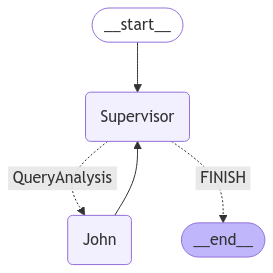

In [44]:
from IPython.display import Image, display
display(Image(query_graph.get_graph().draw_mermaid_png()))

In [45]:
for s in query_graph.stream(
    {
        "messages": [HumanMessage(
            content="Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement. However, critics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias. Additionally, some governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability."
        )]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='Recent studies suggest that over 70% of people globally support the use of artificial intelligence in law enforcement.  \nCritics argue that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias.  \nSome governments claim that implementing AI surveillance has reduced crime rates by as much as 40%, but human rights organizations dispute these figures, stating that the data lacks transparency and reliability.', additional_kwargs={}, response_metadata={}, name='John')]}}
---
{'Supervisor': {'next': 'QueryAnalysis'}}
---
{'John': {'messages': [HumanMessage(content='1. The claim that over 70% of people globally support the use of artificial intelligence in law enforcement requires verification of the studies and their methodologies.  \n2. The assertion that AI-based policing systems have led to a 50% increase in wrongful arrests due to algorithmic bias needs 

KeyboardInterrupt: 